# UFO

<font color='#660066'>
   
### Table of Contents

- [Data](#Data)
    - [Scraping from UFORC](#Scraping-from-UFORC)
    - [Data Format](#data_format)
    - [Cleaing Data](#cleaning_pdata)
- [Basic anlayis](#Basic-Anylsis)
- [Milestone 3](#milestones)

In [1]:
%load_ext autoreload
%autoreload 2
import json
import pandas as pd
from lib.scraping import fetch_shape_urls,  \
                     fetch_all_sighting_urls, \
                     store_to_json, \
                     build_report_dataframe
from lib.postprocessing import get_time_of_occurrence, \
                           to_datetime_add_year, \
                           replace_empty_with_nan, \
                           distribution_histogram 
from lib.cleaning import post_process, \
                         split_summary, \
                         sightings_per_state_unnormalized
from lib.nuforc_analysis import *

In [2]:
data_folder = "data/"

file_url_list = data_folder+'full_list_of_urls.json'

report_file = 'all_sightings_10k_sample.json'

<font color='#660066'>
   
# Data

## Scraping from UFORC

The National UFO Reporting Center (**NUFORC**) lists reports splitted by the occured date, by posting date, by shape or by location. These sightings has been collected since 1974. NUFORC provides a [Hotline](http://www.nuforc.org/Report.html) or [web formular]() to submit the UFO encounters. These reports are checked for hoax and fake reporst, according to [several reports](https://www.reddit.com/r/UFOs/comments/6h5jfc/nuforc_filters_their_reports_much_better_than/). The sightings also include articles from news papers and historical accounts.

We decided to scrape the data from their web page using the *request* and *beatifulsoup* libraries. 

The first step to fetch all the possible shapes and then we can fetch all the urls from each of the shape. 



In [20]:
all_shapes = fetch_shape_urls()
all_reporting_urls = fetch_all_sighting_urls(all_shapes)

<font color='#660066'>

Let's see how many shapes and reportings there are: 

In [ ]:
print("Number of shapes:", len(all_shapes))
print("Nubmer of sighting:", len(all_reporting_urls))

<font color='#660066'>

We don't want to constantly send requests to the server, therefore store the file in urls in a json file. 

In [ ]:
store_to_json(all_reporting_urls, file_url_list)

In [3]:
# import href list of each report
with open(file_url_list) as train_file:
    href_data = json.load(train_file)
urls_to_read = href_data['url']['0']

<font color='#660066'>

Now we are ready to fetch all the reports and convert it to a Pandas Dataframe.

In [ ]:
%%time
df_reports = build_report_dataframe(urls_to_read)

In [ ]:
df_reports.to_json(data_folder+"all_sightings.json")

<font color='#660066'>

The whole scraping process took more than 1 hour. 

<font color='#660066'>
    
## Loading data

of course we dont want so scrape every time

In [3]:
df_reports = pd.read_json(data_folder+report_file)
df_reports.sample(1).head()

,Duration,Location,Occurred,Posted,Reported,Shape,Summary,url
4195,10 minutes,"Escondido, CA",11/7/2015 18:00 (Entered as : 11/07/15 18:00),11/12/2015,11/7/2015 7:05:53 PM 19:05,Changing,"Fire ball into sky, followed by blue lighted m...",http://www.nuforc.org/webreports/123/S123622.html


<font color='#660066'>
   
The data contains the following columns: 

- Occurred
- Reported
- Posted
- Location
- Shape
- Duration
- Summary

The following sections analyze these data throughly. 

<font color='#660066'>
    
## Cleaning data

Let's see how many are not fetched:

In [ ]:
not_found_reports = df_reports[pd.isnull(df_reports.Summary)]
print("Not found reports", not_found_reports.count()['url'])

<font color='#660066'>

These are reports which were not fetched correctly, we have to investigate further why these are missing. 

In [ ]:
df_every_thing = df_reports.rename(index=str, columns={'Occurred ':'Occurred'})

<font color='#660066'>

In our dataset we noticed there are several emtpy strings. <br/>
We decided exchange these empty strings with NaN for easier parsing. 

In [ ]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Occurred')

<font color='#660066'>

The function below does raw post processing on the scraped data such as cleaning whitespace, renaming the columns, ordering the columns and applies filters so that we only retrieve the desired data wich contains summary data and sufficient information for the states.


In [6]:
df_ufo_reports = post_process(df_reports)

splitting Location..
cleaning Location..
cleaning State..
cleaning Reported
cleaning Posted..
re-ordering columns..
done


/Users/josefweber/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/josefweber/Documents/UNI/WS-18/Applied Data Science/project/ada_project/lib/cleaning.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_ufo_reports['Location'] = df_ufo_reports['Location'].apply(lambda x: x.strip()) # 333ys


<font color='#660066'>

Spliting of
- all nuforc notes of each summary into a seperate column 
- all links of each summary into a seperate column 


In [7]:
df_ufo_reports = split_summary(df_ufo_reports)

#### After Cleaning the data our dataframe looks like this

In [8]:
df_ufo_reports[["Summary","nuforc_note","link"]].sample(5)

,Summary,nuforc_note,link
1050,We were driving east bound on M-25 in Lexingto...,[],[]
3803,Referred to Marilyn Childs to call CO state di...,[],[]
4902,"looked like a big white plastic bag, but it sl...",[((NUFORC Note: Witness elects to remain tota...,[]
5463,"A Group of 9 Lights in 2 Rows flying south, sl...",[],[]
3408,Four children left home to go sledding on a hi...,[],[]


<font color='#660066'>

### Occurred / Reported / Posted

In [ ]:
converted = get_time_of_occurrence(df_every_thing)

<font color='#660066'>
Fro the plot above, we use a subsample of 1000 elements. 

To check the distribution of the occurance, wea are plotting the year at which the occurance has been noticed. <br />
The first occurance time is noted as 1400 AD, as a reference to a painting with a descriptive drawing of a plausible UFO.

In [ ]:
distribution_histogram(converted, 'year')

<font color='#660066'>
    
### Location

<font color='#660066'>

As most of the reportings are from the US, we are showing the distribution of reports from the different states. <br />
The data is not normalized at the moment.

In [24]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Location')

NameError: name 'df_every_thing' is not defined

In [14]:
sightings_per_state_unnormalized(df_ufo_reports)

<font color='#660066'>

### Shape

<font color='#660066'>

The shapes feature consist of 31 different shapes, with the most populated being a 'light source'.

In [ ]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Shape')

<font color='#660066'>
    
### Duration

<font color='#660066'>

The duration is a user created data format, with lots of different formats, thus the cleaning and parsing of this data will take a large effort.

In [ ]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Duration')

<font color='#660066'>

### Summary

<font color='#660066'>

User made input as the summary about the witnessed UFO sighting of varying length. 

In [ ]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Shape')

<font color='#660066'>
   

## Milestone 3

- Analyze words, keywords. 
- Read into sentiment analysis, to see if we can apply it to our case.
- Clean duration column
- Analyze if the people were at the time of the sighting
- Split NUFORC nodes
- Check for NUFORC generated HOAX messages
- Check out dem videos
- Keywords for sleep, dropping the reports which might have been dreams/sleep paralysis induced visions.
- Time of occurance/duration correlation
- Weather data (historic weather data, cloudy, sunny, storm, etc), general trends in US states (months with higher percipitation), sort the data by month and see which months have a higher rate of sightings (look in the years where there are the most sightings)
- Filter out MADAR data, see how much our dataset changes
- Analyze what shapes are associated with what feelings? 
- Analyze what shapes are consistently reported at same locations?

- Sentiment Analysis for summary text
    - start with vizualization of text
    ([inspiration](https://www.jasondavies.com/wordtree/?source=obama.inauguration.2013.txt&prefix=we%20must%20act))
- Correlation of weather and reports
- Analyze madar sensor data (also in correlation with weather)
- Create report results plots (webpage)


<font color='#660066'>

## NUFORC Note Analyse

Distribution of NUFORC notes

In [15]:
dist = get_noforc_note_count_distribution(df_ufo_reports)
dist

0    6999
1    2779
2     202
3      10
Name: nuforc_note, dtype: int64

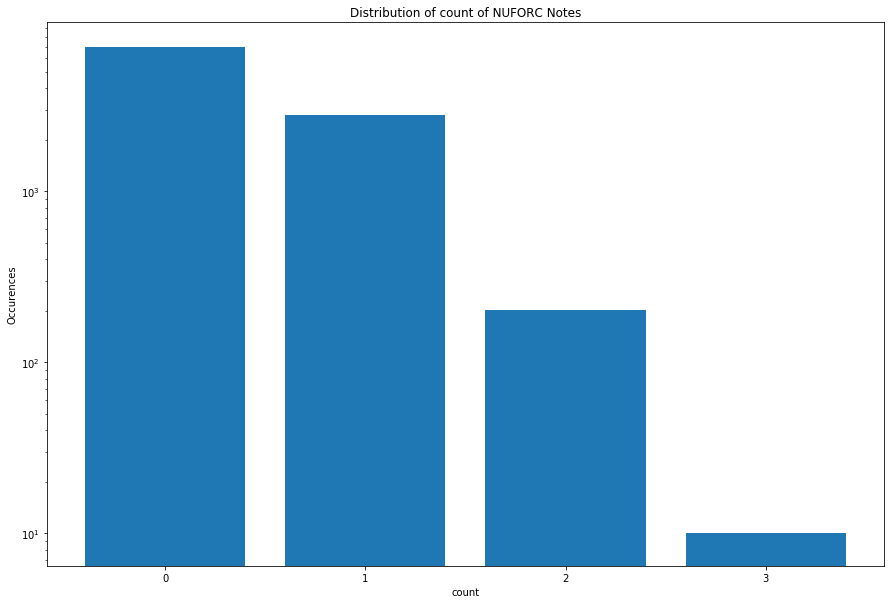

In [16]:
plot_distribution_of_notes(df_ufo_reports)


<font color='#660066'>

Filter all reports having n NUFORC Notes

In [9]:
get_reports_having_n_notes(df_ufo_reports, 3).head()

,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,url,nuforc_note,link
1502,5 days,Thompson (Canada),MB,10/15/2006 22:00 (Entered as : 10/06 22:00),2/1/2007,1/20/2007 1:58:24 PM 13:58,,Orions Belt *nebula (faint) out in ...,http://www.nuforc.org/webreports/054/S54860.html,[((NUFORC Note: Source of report indicates th...,[]
1617,,Ada,OK,6/30/2005 22:30,10/10/2011,10/7/2011 10:38:57 AM 10:38,,Three UFOs in triangle form move in unison aft...,http://www.nuforc.org/webreports/084/S84383.html,[((NUFORC Note: Second report from Oklahoma t...,[]
252,,Camden,AR,7/3/2017 23:30 (Entered as : 07/03/2017 11:30),7/7/2017,7/6/2017 1:30:15 PM 13:30,,IT WAS THIS WEIRD LOOKING SPECIES ON MY SCREEN...,http://www.nuforc.org/webreports/134/S134987.html,"[((NUFORC Note: Either a moth, a grasshopper,...",[]
260,,Unknown location (military video),,6/4/2017,6/9/2017,6/4/2017 3:00:54 AM 03:00,,They are not birds. NOT BIRDS ! @ 00:36 The ...,http://www.nuforc.org/webreports/134/S134424.html,[((NUFORC Note: Report addresses a video abou...,"[https://www.youtube.com/watch?v=dL9_Tldmrhs, ..."
4258,3 minutes,Mount Juliet,TN,6/22/2015 22:40 (Entered as : 06/22/2015 22:40),6/24/2015,6/23/2015 9:34:16 AM 09:34,Changing,Compact semi-transparent cloud-shape moving NN...,http://www.nuforc.org/webreports/119/S119717.html,[((NUFORC Note: Witness elects to remain tota...,[http://spaceflightnow.com/2015/06/22/vv05-mis...


# Extracting the links

# Extracting the links

In [10]:
dist = df_ufo_reports["link"].str.len().value_counts()
dist

0    9733
1     209
2      37
3      10
4       1
Name: link, dtype: int64

In [11]:
res = df_ufo_reports[df_ufo_reports["link"].str.len() == 1]
res

,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,url,nuforc_note,link
1012,4-5 minutes,Bridgewater,NJ,11/23/2011 00:45 (Entered as : 11/23/11 00:45),6/5/2012,6/5/2012 12:37:48 PM 12:37,,EXPLAINED: Bright lights in Somerset county NJ...,http://www.nuforc.org/webreports/089/S89377.html,[((NUFORC Note: Witness elects to remain tota...,[http://www.nj.com/news/index.ssf/2011/11/brig...
1022,,Uncasville,CT,10/20/2011 (Entered as : 10-20-11),12/12/2011,11/2/2011 10:08:59 PM 22:08,,The sighting in CT was prophesied on my Facebo...,http://www.nuforc.org/webreports/085/S85110.html,[],[http://www.facebook.com/#!/beckah.cook]
1042,,Morgan's Hill (UK/England),,8/1/2011 (Entered as : 08/01/11),5/13/2012,5/12/2012 9:19:48 AM 09:19,,"A couple of yrs ago, I posted a sighting we ex...",http://www.nuforc.org/webreports/088/S88913.html,[],[http://www.nuforc.org/webreports/049/S49530.h...
1054,approx: 1 hour,Montreal (Lanaudière region) (Canada),,6/10/2011 21:52 (Entered as : 06/10/2011 21:52),6/27/2011,6/20/2011 11:43:30 PM 23:43,,"In less than a hour, 4 sightings were captured...",http://www.nuforc.org/webreports/081/S81864.html,[],[http://www.youtube.com/watch?v=mhg9IjgsIrg]
1079,,Vancouver,WA,2/20/2011 19:45 (Entered as : 02/20/2011 19:45),2/23/2011,2/22/2011 11:42:33 PM 23:42,,"Video found online of Vancouver, WA UFO. I ...",http://www.nuforc.org/webreports/080/S80189.html,[((NUFORC Note: Witness elects to remain tota...,[http://www.kgw.com/your-pics/116580163.html]
1103,unknown,Queretaro City (Mexico),,10/23/2010 18:00 (Entered as : 10/23/10 18:00),11/21/2010,10/25/2010 10:44:44 AM 10:44,,"published in a local diary ""diario de queretar...",http://www.nuforc.org/webreports/078/S78555.html,[],[http://www.oem.com.mx/diariodequeretaro/porta...
1115,,Olin,NC,9/7/2010 (Entered as : 09/07/10),11/21/2010,9/7/2010 7:51:21 AM 07:51,,Related UUO/UFO activity vicinity of NC Coast ...,http://www.nuforc.org/webreports/077/S77685.html,[],[http://www.googleearthanomalies.com/Anomalies...
1140,,Glacier National Park (??),MT,6/30/2010 12:00 (Entered as : 2010 12:00),5/29/2011,5/18/2011 12:07:14 PM 12:07,,unknown footageI am a filmmaker. I bought a u...,http://www.nuforc.org/webreports/081/S81304.html,[((NUFORC Note: Witness elects to remain tota...,[http://www.youtube.com/user/SuperNoneyo?featu...
1157,,Alberta (Canada),AB,4/12/2010,4/13/2010,4/12/2010 2:08:36 PM 14:08,,I simply wanted to share a video I posted at y...,http://www.nuforc.org/webreports/074/S74994.html,[((NUFORC Note: Witness elects to remain tota...,[http://ca.video.yahoo.com/watch/2649936/7770079]
1164,,,,3/22/2010 19:45 (Entered as : 22/03/2010 07:...,4/13/2010,4/3/2010 1:00:37 PM 13:00,,,http://www.nuforc.org/webreports/074/S74875.html,[((NUFORC Note: Witness elects to remain tota...,[http://www.youtube.com/watch?v=gnuo32-tc3w]


In [12]:
a=list(res["link"])
a

[['http://www.nj.com/news/index.ssf/2011/11/bright_flashes_of_light_widesp.html'],
 ['http://www.facebook.com/#!/beckah.cook'],
 ['http://www.nuforc.org/webreports/049/S49530.html'],
 ['http://www.youtube.com/watch?v=mhg9IjgsIrg'],
 ['http://www.kgw.com/your-pics/116580163.html'],
 ['http://www.oem.com.mx/diariodequeretaro/portada_impresa.aspx'],
 ['http://www.googleearthanomalies.com/Anomalies/tabid/56/articleType/ArticleView/articleId/31/Topographic-Anomalies-NC-Area.aspx'],
 ['http://www.youtube.com/user/SuperNoneyo?feature=mhee'],
 ['http://ca.video.yahoo.com/watch/2649936/7770079'],
 ['http://www.youtube.com/watch?v=gnuo32-tc3w'],
 ['http://www.youtube.com/watch?v=KikkGlCAKHw'],
 ['http://www.'],
 ['http://i59.photobucket.com/albums/g304/FTTOUFO/sighting.jpg'],
 ['http://www.news.com.au/story/0,23599,24070088-13762,00.htmlMoon-walker'],
 ['http://www.thesun.co.uk/sol/homepage/news/article1315843.ece'],
 ['http://www.phnompenhpost.com/index.php/200805304807/National-news/Police-lau